In [1]:
# Configuration Section
import os
import datetime
import json
from pathlib import Path
import gymnasium as gym
import ale_py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation, RecordVideo, TransformReward
from agents.reinforce import ReinforcePolicyGradientsAgent
from agents.dqn import DQNAgent
from models.cnns import CNNBackbone
from wrappers.gym_wrappers import ProgressiveRewardWrapper, ChannelFirstWrapper, NormalizeWrapper, ChannelWiseFrameStack, StopOnRoundEndWrapper

# Enable autoreload for all modules
%load_ext autoreload
%autoreload 2

# Training Configuration
CONFIG = {
    # Environment Settings
    "env_name": "ALE/Surround-v5",
    "game": "Surround",
    "mode": 2,
    "difficulty": 1,
    "frameskip": 6,
    
    # Directory Settings
    "base_dir": "./experiments",
    "video_subdir": "videos",
    "checkpoint_subdir": "checkpoints",
    "log_subdir": "logs",
    
    # Training Settings
    "num_episodes": 1000,
    "render_every_n": 5,
    "save_every_n": 5,
    
    # Environment Preprocessing
    "screen_size": 84,
    "grayscale": True,
    "frame_stack": 0,  # Set to 0 to disable
    "normalize": False, # Don't use this, normalization built into AtariPreprocessing wrapper
    "base_survival_reward": 0.01,  # Lower base reward since it will scale up
    # "survival_scaling_factor": 1.05, # Exponential growth factor
    "reward_scaling_factor": 1, # Scaling factor for rewards
    "stop_on_round_end": True,

    # Agent Selection
    # "agent_type": "reinforce",  # Options: "reinforce" or "dqn"
    "agent_type": "dqn",
    
    # Shared Agent Settings
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "learning_rate": 1e-3, 
    "gamma": 0.95, # Discount factor
    "use_cnn": True,
    
    # REINFORCE-specific settings
    "reinforce": {
        "max_grad_norm": 0.5,
        "entropy_coef": 1e-4,
        # Network architecture
        "cnn_channels": [32, 64, 64],
        "cnn_kernel_sizes": [3, 3, 3],
        "cnn_strides": [2, 2, 1],
        "hidden_dims": [512]
    },
    
    # DQN-specific settings
    "dqn": {
        # Network architecture
        "cnn_channels": [32, 64, 64],
        "cnn_kernel_sizes": [8, 4, 3],
        "cnn_strides": [4, 2, 1],
        "hidden_dims": [64, 32],
        
        # Buffer settings
        "buffer_size": 100000,
        "batch_size": 64,
        "target_update_freq": 1, # Update target network every n steps, set to 1 (or something low) for soft update
        "tau": 0.001, # Soft update parameter, if 1 then hard update
        "update_freq": 1,
        "gradient_clip": 1.0,
        
        "eps_start": 1.0,
        "eps_end": 0.05,
        "eps_decay": 0.995,
        "double_dqn": True,
        
        "per_alpha": 0.6,
        "per_beta_start": 0.4,
        "per_beta_end": 1.0,
        "per_beta_steps": 100000
    }
}


In [2]:

# Create experiment directory structure
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_dir = Path(CONFIG["base_dir"]) / f"{CONFIG['game']}_{CONFIG['agent_type']}_{timestamp}"

for subdir in [CONFIG["video_subdir"], CONFIG["checkpoint_subdir"], CONFIG["log_subdir"]]:
    (experiment_dir / subdir).mkdir(parents=True, exist_ok=True)

# Save configuration
with open(experiment_dir / "config.json", "w") as f:
    json.dump(CONFIG, f, indent=4)

In [3]:

def create_env(config):
    """Create and wrap the environment according to configuration."""
    env = gym.make(
        config["env_name"],
        render_mode="rgb_array",
        mode=config["mode"],
        difficulty=config["difficulty"],
        frameskip=config["frameskip"]
    )

    # Naive Stop on round end wrapper to detect end via reward (1 or -1)
    if config["stop_on_round_end"]:
        env = StopOnRoundEndWrapper(env, stop_reward=1)

    # Progressive reward wrapper
    # env = ProgressiveRewardWrapper(
    #     env,
    #     base_survival_reward=config["base_survival_reward"]
    # )
    env = TransformReward(env, lambda r: r + config["base_survival_reward"])

    if config["reward_scaling_factor"] != 1:
        env = TransformReward(env, lambda r: r * config["reward_scaling_factor"])
    
    # Preprocessing wrappers
    env = AtariPreprocessing(
        env,
        noop_max=15,
        frame_skip=1,
        screen_size=config["screen_size"],
        scale_obs=True,
        grayscale_obs=config["grayscale"],
        grayscale_newaxis=config["grayscale"] # add channel dim
    )

    # Video wrapper
    env = RecordVideo(
        env,
        video_folder=str(experiment_dir / config["video_subdir"]),
        episode_trigger=lambda episode_id: episode_id % config["render_every_n"] == 0,
        fps=60
    )
    
    env = ChannelFirstWrapper(env)
    
    if config["frame_stack"] > 0:
        env = FrameStackObservation(env, config["frame_stack"])
        env = ChannelWiseFrameStack(env)
    
    if config["normalize"]:
        env = NormalizeWrapper(env)
    
    return env

def create_agent_from_config(config: dict, env: gym.Env):
    """
    Creates an agent instance from a configuration dictionary by automatically
    mapping config parameters to constructor arguments.
    
    The function combines common parameters with agent-specific ones and uses
    dictionary unpacking for clean initialization.
    """
    # Common parameters shared across all agents
    common_params = {
        "env": env,
        "device": config.get("device", "cpu"),
        "use_cnn": config.get("use_cnn", False),
        "lr": config.get("learning_rate", 1e-3),
        "gamma": config.get("gamma", 0.99)
    }
    
    agent_type = config["agent_type"].lower()
    
    # Get the appropriate agent class
    agent_classes = {
        "reinforce": ReinforcePolicyGradientsAgent,
        "dqn": DQNAgent
        # Add more agents here as needed
    }
    
    if agent_type not in agent_classes:
        raise ValueError(f"Unknown agent type: {agent_type}")
    
    agent_class = agent_classes[agent_type]
    
    # Combine common parameters with agent-specific ones
    agent_params = {**common_params}
    if agent_type in config:
        agent_params.update(config[agent_type])
    
    # Create and return the agent instance using dictionary unpacking
    return agent_class(**agent_params)

In [4]:
def plot_training_history(history, save_dir):
    """Plot and save training metrics."""
    df = pd.DataFrame(history)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Define metrics groupings
    value_metrics = ['total_return', 'mean_q_value']  # DQN and REINFORCE
    loss_metrics = ['q_loss', 'policy_loss', 'entropy_loss', 'total_loss']  # Combined
    auxiliary_metrics = ['eps']  # DQN-specific
    
    # Filter to only metrics present in the data
    value_metrics = [m for m in value_metrics if m in df.columns]
    loss_metrics = [m for m in loss_metrics if m in df.columns]
    auxiliary_metrics = [m for m in auxiliary_metrics if m in df.columns]
    
    # Determine number of subplot rows needed
    n_rows = (bool(value_metrics) + bool(loss_metrics) + bool(auxiliary_metrics))
    
    # Create combined figure
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, 5*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    current_ax = 0
    
    # Plot value metrics
    if value_metrics:
        ax = axes[current_ax]
        for metric in value_metrics:
            ax.plot(df[metric], label=metric)
        ax.set_title('Value Metrics')
        ax.set_xlabel('Episode')
        ax.legend()
        current_ax += 1
    
    # Plot loss metrics
    if loss_metrics:
        ax = axes[current_ax]
        for metric in loss_metrics:
            ax.plot(df[metric], label=metric)
        ax.set_title('Loss Metrics')
        ax.set_xlabel('Episode')
        ax.legend()
        current_ax += 1
    
    # Plot auxiliary metrics
    if auxiliary_metrics:
        ax = axes[current_ax]
        for metric in auxiliary_metrics:
            ax.plot(df[metric], label=metric)
        ax.set_title('Auxiliary Metrics')
        ax.set_xlabel('Episode')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(save_dir / "training_history.png")
    plt.close()
    
    # Also save individual plots
    all_metrics = df.columns.tolist()
    excluded_metrics = {'total_steps', 'buffer_size'}
    
    for metric in all_metrics:
        if metric not in excluded_metrics:
            plt.figure(figsize=(10, 6))
            plt.plot(df[metric])
            plt.title(metric)
            plt.xlabel('Episode')
            plt.ylabel(metric)
            plt.savefig(save_dir / f"{metric}_history.png")
            plt.close()

In [5]:

def save_checkpoint(agent, episode, history, save_dir, config):
    """Save agent checkpoint and training history."""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create checkpoint directory if it doesn't exist
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Save agent state
    agent_path = save_dir / f"agent_{config['agent_type']}_episode_{episode}_{timestamp}.pth"
    agent.save(agent_path)
    
    # Save training state
    checkpoint = {
        'episode': episode,
        'history': history,
        'config': config
    }
    checkpoint_path = save_dir / f"training_state_episode_{episode}_{timestamp}.pt"
    torch.save(checkpoint, checkpoint_path)
    
    return agent_path, checkpoint_path

def load_checkpoint(checkpoint_path, env):
    """Load agent checkpoint and return training state."""
    checkpoint = torch.load(checkpoint_path)
    config = checkpoint['config']
    
    # Create agent with saved configuration
    agent = create_agent_from_config(config, env)
    agent.load(checkpoint_path)
    
    return agent, checkpoint['episode'], checkpoint['history'], config


In [6]:


def main(config):
    # Create experiment directory
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_name = f"{config['game']}_{config['agent_type']}_{timestamp}"
    experiment_dir = Path(config["base_dir"]) / experiment_name
    
    # Create subdirectories
    for subdir in [config["video_subdir"], config["checkpoint_subdir"], config["log_subdir"]]:
        (experiment_dir / subdir).mkdir(parents=True, exist_ok=True)
    
    # Save configuration
    with open(experiment_dir / "config.json", "w") as f:
        json.dump(config, f, indent=4)
    
    # Create environment and agent
    env = create_env(config)
    agent = create_agent_from_config(config, env)
    
    print(f"\nAgent Type: {config['agent_type'].upper()}")
    print("Model Architecture:")
    print(agent.model if hasattr(agent, 'model') else agent.q_network)
    print("\nObservation Space:", env.observation_space)
    
    # Reset the environment and get the initial observation
    observation, _ = env.reset()

    # Check if the observation is channel-first (C, H, W) and permute if necessary
    if observation.shape[0] == 3 or observation.shape[0] == 1:
        observation = np.transpose(observation, (1, 2, 0))  # Convert to (H, W, C)

    # Plot and save the observation as an image to preview and view preprocessing
    plt.imshow(observation)
    plt.axis('off')  # Turn off axis
    image_path = experiment_dir / "model_obs_example.jpg"
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
    plt.show()

    # Training loop
    history = []
    
    for episode in range(config["num_episodes"]):
        # Run episode
        results = agent.run_episode(env)
        history.append(results)
        
        # Print progress
        print(f"Episode {episode + 1}/{config['num_episodes']}: {results}")
        
        # Save checkpoint
        if (episode + 1) % config["save_every_n"] == 0:
            agent_path, checkpoint_path = save_checkpoint(
                agent,
                episode + 1,
                history,
                experiment_dir / config["checkpoint_subdir"],
                config
            )
            print(f"Saved checkpoint: {checkpoint_path}")

            # Plot training history
            plot_training_history(history, experiment_dir / config["log_subdir"])
    
    # Final save
    agent_path, checkpoint_path = save_checkpoint(
        agent,
        config["num_episodes"],
        history,
        experiment_dir / config["checkpoint_subdir"],
        config
    )
    
    # Plot training history
    plot_training_history(history, experiment_dir / config["log_subdir"])
    
    return agent, history, env, experiment_dir

A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]
/home/bytemarish/miniconda3/envs/slitherl/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/bytemarish/ACM_AI/SlitheRL_Cleaned/experiments/Surround_dqn_20250208_165418/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


CNN feature output shape: torch.Size([1, 3136])
CNN feature output shape: torch.Size([1, 3136])

Agent Type: DQN
Model Architecture:
CNNBackbone(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (hidden_layers): ModuleList(
    (0): Linear(in_features=3136, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
)

Observation Space: Box(0.0, 255.0, (1, 84, 84), float32)


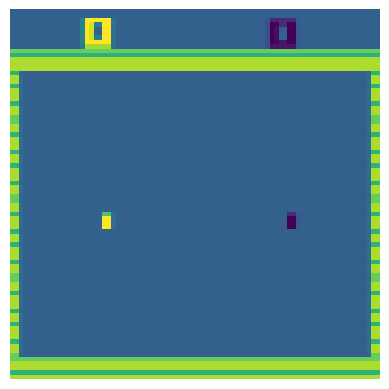

Episode 1/1000: {'total_return': 6.099999999999994, 'steps': 62, 'total_steps': 62, 'eps': 1.0, 'buffer_size': 62, 'q_loss': 0.0, 'mean_q_value': 0.0, 'max_q_value': 0.0, 'min_q_value': 0.0, 'mean_td_error': 0.0, 'max_td_error': 0.0, 'mean_weight': 0.0}
Episode 2/1000: {'total_return': 6.799999999999992, 'steps': 69, 'total_steps': 131, 'eps': 0.995, 'buffer_size': 131, 'q_loss': 0.006782005094197195, 'mean_q_value': 0.14368829199606004, 'max_q_value': 0.19285807188819437, 'min_q_value': 0.09313061197890955, 'mean_td_error': 0.12098541, 'max_td_error': 0.18651696, 'mean_weight': 0.6963313081685234}
Episode 3/1000: {'total_return': 1.7000000000000004, 'steps': 18, 'total_steps': 149, 'eps': 0.990025, 'buffer_size': 149, 'q_loss': 0.007154792159174879, 'mean_q_value': 0.12019908221231566, 'max_q_value': 0.1506220872203509, 'min_q_value': 0.09914099135332638, 'mean_td_error': 0.12777853, 'max_td_error': 0.1553881, 'mean_weight': 0.8327708890040716}
Episode 4/1000: {'total_return': 7.39999

In [7]:
agent, history, env, exp_dir = main(CONFIG)